In [1]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

from tqdm.auto import tqdm
import string
import unicodedata
import re
import math
import random

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
seed = 42

random.seed(seed)  # Python rastgele sayı üreticisine seed ayarla
np.random.seed(seed)  # NumPy rastgele sayı üreticisine seed ayarla
torch.manual_seed(seed)  # CPU için seed ayarla
torch.cuda.manual_seed(seed)  # GPU için seed ayarla (CUDA kullanıyorsanız)
torch.cuda.manual_seed_all(seed)  # Birden fazla GPU kullanıyorsanız
torch.backends.cudnn.deterministic = True  # Deterministik işlemler için
torch.backends.cudnn.benchmark = False  # Performans iyileştirmelerini devre dışı bırak


In [3]:
data = pd.read_csv("/kaggle/input/data/data.csv", encoding="utf-8-sig")
data

,review,sirket,sentiment
0,"kaira, müşteri memnuniyetini ön planda tutarak...",kaira,olumlu
1,vodafone tarife pahalılığı ile ilgili sorun ya...,vodafone,olumsuz
2,"jbl’in şarj süresi genellikle yeterlidir, anca...","jbl,bose","olumlu,olumsuz"
3,digiturk'te yapılmayan ücret i̇adesi. yıllık ...,digiturk,olumsuz
4,"bimcell yeni hat alana verdiği 9 gb, 300 sms v...",bimcell,olumsuz
...,...,...,...
40592,"netflix, dizi ve film izleme konusunda çeşitli...",netflix,nötr
40593,i̇gdaş 48 günlük fatura. bize mart ayı 676 tl ...,i̇gdaş,olumsuz
40594,"daniel klein’in koleksiyonları geniş, fakat ba...","daniel klein,tag heuer,tissot","olumsuz,olumlu,olumlu"
40595,"eczacıbaşı holding’in kurumsal yapısı, diğer b...","eczacıbaşı holding,koç holding,sabancı holding...","nötr,nötr,nötr,nötr,nötr"


In [4]:
tokenizer = Tokenizer.from_file("/kaggle/input/data/tokenizer.json")

In [5]:
class CustomDataset(Dataset):
    def __init__(self, texts, input_ids, attention_masks, token_type_ids, labels):
        self.texts = texts
        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_masks = attention_masks
        self.labels = labels


    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item ):
        text = self.texts[item]
        input_id = torch.LongTensor(self.input_ids[item])
        token_type_id = torch.LongTensor(self.token_type_ids[item])
        attention_mask = torch.LongTensor(self.attention_masks[item])
        label = torch.LongTensor(self.labels[item])


        return {
            'text': text,
            'input_ids': input_id,
            'token_type_ids': token_type_id,
            'attention_mask': attention_mask,
            'labels': label,
        }

In [6]:
def tag_and_sent_sentence(sentence, company_names, sentiments):

    words = tokenizer.encode(sentence).tokens
    tags = ["O"] * len(words)
    company_names = company_names.split(",")
    sentiments = sentiments.split(",")
    try:
        for company,sentiment in zip(company_names,sentiments):
            company_words = company.split()
            for i in range(len(words) - len(company_words) + 1):
                words = [unicodedata.normalize('NFC', word) for word in words]
                company_words = [unicodedata.normalize('NFC', word) for word in company_words]
                if words[i:i + len(company_words)] == company_words:
                    tags[i] = "B-COMPANY"+f"_{sentiment}"
                    for j in range(1, len(company_words)):
                        tags[i + j] = "I-COMPANY"
    except:print(company_names,sentiments)
    

    return list(zip(words, tags))

In [7]:
tagged_sentences = [tag_and_sent_sentence(sentence, sirketler, sentiments) for sentence, sirketler, sentiments in tqdm(data[["review","sirket","sentiment"]].values)]

  0%|          | 0/40597 [00:00<?, ?it/s]

In [8]:
tag2id = {"O": 0, "B-COMPANY_olumsuz": 1, "B-COMPANY_nötr": 2, "B-COMPANY_olumlu": 3, "I-COMPANY": 4}
id2tag = {value: key for key, value in tag2id.items()}

labels = [[tag for word, tag in sentence] for sentence in tagged_sentences]
labels = [[tag2id[tag] for tag in doc] for doc in labels]

In [9]:
from collections import Counter
Counter([label for labelx in labels for label in labelx])

Counter({0: 5106335, 1: 34120, 3: 23382, 4: 21243, 2: 11336})

In [10]:
encodings = [tokenizer.encode(text) for text in tqdm(data["review"].values)]

  0%|          | 0/40597 [00:00<?, ?it/s]

In [11]:
texts = [encoded.tokens for encoded in encodings]
input_ids = [encoded.ids for encoded in encodings]
attention_masks = [encoded.attention_mask for encoded in encodings]
token_type_ids = [encoded.type_ids for encoded in encodings]

In [12]:
class FeedForwardSubLayer(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForwardSubLayer, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForwardSubLayer(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        return self.norm2(x + self.dropout(ff_output))


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Set the number of attention heads
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % num_heads == 0 #dimension, headlere tam bölünüyormu kontrol et.
        
        self.head_dim = d_model // num_heads
        # Set up the linear transformations
        self.query_linear = nn.Linear(d_model, d_model)
        self.key_linear = nn.Linear(d_model, d_model)
        self.value_linear = nn.Linear(d_model, d_model)
        self.output_linear = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        # sequenceyi başlıklar arasında böl
        x = x.view(batch_size, -1, self.num_heads, self.head_dim)
        return x.permute(0, 2, 1, 3) 

    def compute_attention(self, query, key, mask=None):
        # Compute dot-product attention scores
        scores = torch.matmul(query, key.permute(0,1,3,2))
        mask = mask.unsqueeze(1).unsqueeze(1)


        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-1e20"))
        # Normalize attention scores into attention weights
        attention_weights = F.softmax(scores, dim=-1)
        return attention_weights

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        query = self.split_heads(self.query_linear(query), batch_size)
        key = self.split_heads(self.key_linear(key), batch_size)
        value = self.split_heads(self.value_linear(value), batch_size)

        attention_weights = self.compute_attention(query, key, mask)

        output = torch.matmul(attention_weights, value)
        output = output.view(batch_size, self.num_heads, -1, self.head_dim).permute(0, 2, 1, 3).contiguous().view(
            batch_size, -1, self.d_model)
        return self.output_linear(output)

class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_length):
        super(PositionalEncoder, self).__init__()
        self.d_model = d_model
        self.max_length = max_length

        pe = torch.zeros(max_length, d_model)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * -(math.log(10000.0) / d_model))

        # Calculate and assign position encodings to the matrix
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x
    
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoder(d_model, max_sequence_length)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

    def forward(self, x, mask):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, mask)
        return x

In [13]:
num_classes = 5 #tahmin edilcel class sayısı, 0-1-2-3-4
vocab_size = 100000 #sözlüğümüzdeki kelime sayısı
batch_size = 32 #tensorler kaçlık batchler halinde olacak
d_model = 512 # modelin dimensionu
num_heads = 8 #kaç tane attention olacak, multihead attention sayısı, burada 8 farklı context vektör tanımladık.
num_layers = 6 #6 tane encoder katmanı yapıyoruz, sırasıyla birbirlerine çıktılarını veriyolar.
d_ff = 2048 #linear layer 
sequence_length = 128 #metin uzunluğu
dropout = 0.1 #unutma katsayısı

In [14]:
dataset = CustomDataset(texts, input_ids, attention_masks, token_type_ids, labels)
dataset_val,dataset_test, dataset_train  = torch.utils.data.random_split(dataset, [0.05,0.1,0.85])

dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [15]:
encoder = TransformerEncoder(vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length=sequence_length)

In [16]:
def save_model(model, optimizer, epoch, path="model.pth"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, path)

In [17]:
def train_model(model, train_dataloader, val_dataloader, num_epochs, learning_rate, device, patience=3, lr_factor=0.5):
    model.to(device)
    criterion = nn.CrossEntropyLoss(reduction='none')  # Compute loss for each token separately
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for dataset in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{num_epochs}"):
            batch_input_ids = dataset['input_ids'].to(device)
            batch_att_mask = dataset['attention_mask'].to(device)
            batch_target = dataset['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(batch_input_ids, batch_att_mask)  # Assume no mask for simplicity

            logits = outputs.view(-1, outputs.size(-1))  # Flatten the outputs
            batch_target = batch_target.view(-1)
            batch_att_mask = batch_att_mask.view(-1)

            loss = criterion(logits, batch_target)
            loss = (loss * batch_att_mask).sum() / batch_att_mask.sum()  # Apply attention mask and average

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

        # Validation step (if val_dataloader is provided)
        if val_dataloader is not None:
            model.eval()
            val_loss = 0
            correct = 0
            total = 0
            with torch.no_grad():
                for dataset_val in tqdm(val_dataloader, desc=f"Validation Epoch {epoch + 1}/{num_epochs}"):
                    val_input_ids = dataset_val['input_ids'].to(device)
                    val_att_mask = dataset_val['attention_mask'].to(device)
                    val_target = dataset_val['labels'].to(device)

                    accuracy_mask = (val_target != 0).long()
                    accuracy_mask = accuracy_mask.view(-1)

                    outputs = model(val_input_ids, val_att_mask)

                    logits = outputs.view(-1, outputs.size(-1))
                    val_target = val_target.view(-1)
                    val_att_mask = val_att_mask.view(-1)

                    loss = criterion(logits, val_target)
                    loss = (loss * val_att_mask).sum() / val_att_mask.sum()  # Apply attention mask and average

                    val_loss += loss.item()
                    _, predicted = torch.max(logits, 1)
                    total += accuracy_mask.sum().item()  # Only count the masked tokens
                    correct += ((predicted == val_target) * accuracy_mask).sum().item()  # Only consider masked tokens for accuracy

            avg_val_loss = val_loss / len(val_dataloader)
            accuracy = correct / total
            print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}")

            # Early stopping and learning rate reduction
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                epochs_no_improve = 0
                torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
                print("Model Saved")
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print("Early stopping")
                    break
                if epochs_no_improve % 2 == 0:
                    learning_rate *= lr_factor
                    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                    print(f"Learning rate reduced to {learning_rate}")

    print("Training complete!")
    model.load_state_dict(torch.load('best_model.pth'))  # Load the best model
    print("Loaded the best model")
    return model, optimizer, num_epochs

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [19]:
final_model, optimizer,epoch = train_model(model=encoder,
                              train_dataloader=dataloader,
                              val_dataloader=val_loader,
                              num_epochs=15,
                              learning_rate=1e-4,
                              device=device)

Training Epoch 1/15:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 1, Loss: 0.1170


Validation Epoch 1/15:   0%|          | 0/64 [00:00<?, ?it/s]

Validation Loss: 0.0512, Accuracy: 0.8393
Model Saved


Training Epoch 2/15:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 2, Loss: 0.0401


Validation Epoch 2/15:   0%|          | 0/64 [00:00<?, ?it/s]

Validation Loss: 0.0411, Accuracy: 0.8694
Model Saved


Training Epoch 3/15:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 3, Loss: 0.0276


Validation Epoch 3/15:   0%|          | 0/64 [00:00<?, ?it/s]

Validation Loss: 0.0383, Accuracy: 0.8771
Model Saved


Training Epoch 4/15:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 4, Loss: 0.0207


Validation Epoch 4/15:   0%|          | 0/64 [00:00<?, ?it/s]

Validation Loss: 0.0380, Accuracy: 0.8861
Model Saved


Training Epoch 5/15:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 5, Loss: 0.0174


Validation Epoch 5/15:   0%|          | 0/64 [00:00<?, ?it/s]

Validation Loss: 0.0416, Accuracy: 0.8946


Training Epoch 6/15:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 6, Loss: 0.0143


Validation Epoch 6/15:   0%|          | 0/64 [00:00<?, ?it/s]

Validation Loss: 0.0452, Accuracy: 0.8854
Learning rate reduced to 5e-05


Training Epoch 7/15:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 7, Loss: 0.0085


Validation Epoch 7/15:   0%|          | 0/64 [00:00<?, ?it/s]

Validation Loss: 0.0487, Accuracy: 0.8912
Early stopping
Training complete!
Loaded the best model


In [29]:
def predict(model, dataloader, device, padding_idx=0):
    model.to(device)
    model.eval()
    predictions = []
    confidences = []

    with torch.no_grad():
        for dataset in tqdm(dataloader, desc="Predicting"):
            batch_input_ids = dataset['input_ids'].to(device)
            batch_att_mask = dataset['attention_mask'].to(device)

            outputs = model(batch_input_ids, batch_att_mask)
            logits = outputs.view(-1, outputs.size(-1))  # Flatten the outputs
            probs = F.softmax(logits, dim=1)  # Compute probabilities

            max_probs, predicted = torch.max(probs, dim=1)

            predictions.append(predicted.cpu())
            confidences.append(max_probs.cpu())

    # Concatenate all batch results
    predictions = torch.cat(predictions)
    confidences = torch.cat(confidences)

    return predictions, confidences

In [56]:
example="""Fiber 100mb SuperOnline kullanıcısıyım yaklaşık 2 haftadır 
@Twitch @Kick_Turkey gibi canlı yayın platformlarında 360p yayın izlerken donmalar yaşıyoruz.  
Başka hiç bir operatörler bu sorunu yaşamazken ben parasını verip alamadığım hizmeti neden ödeyeyim ? @Turkcell """

In [42]:
example = """Entity X'in müşteri hizmetleri hızlı ve etkili, Entity Y'nin ürün kalitesi çok
kötü."""

In [39]:
example = """@TurkcellHizmet ya vereceğiniz hizmeti... ya bilader allahın adasında
bile iyi çekerken, şehir merkezinde nasıl çekmiyor bu """

In [54]:
example = """Turkcell, Türkiye merkezli teknolojik iletişim operatör şirketidir."""

In [57]:
encodings_prdict = tokenizer.encode(example)

predict_texts = [encodings_prdict.tokens]
predict_input_ids = [encodings_prdict.ids]
predict_attention_masks = [encodings_prdict.attention_mask]
predict_token_type_ids = [encodings_prdict.type_ids]
prediction_labels = [encodings_prdict.type_ids]

predict_data = CustomDataset(predict_texts, predict_input_ids, predict_attention_masks, predict_token_type_ids, prediction_labels)
predict_loader = DataLoader(predict_data, batch_size=1, shuffle=False)

predict_list, confidences = predict(model=final_model,dataloader=predict_loader,device=device)

Predicting:   0%|          | 0/1 [00:00<?, ?it/s]

In [58]:
result_tokens=[]
for token,prediction,mask,conf in zip(predict_loader.dataset[0]["text"],predict_list.tolist(),predict_attention_masks[0], confidences.tolist()):
    if mask !=0:
        result_tokens.append((token,prediction,f"{conf:.2f}"))
        
from IPython.display import display, HTML
label_to_color = {1:"lightcoral",2:"lightblue",3:"lightgreen"}

html_content = "<div style='font-family: monospace; font-size: 25px;'>"
last_color = ""
for token, label, score in result_tokens:
    if label != 0 and label !=4:
        last_color = label_to_color.get(label)
        html_content += f"<span style='background-color: {last_color};'>{token,score}</span> "
    elif label==4:
        html_content += f"<span style='background-color: {last_color};'>{token}</span> "
    else:
        html_content += f"{token} "
html_content += "</div>"

display(HTML(html_content))

In [27]:
def predict_conf(model, dataloader, device, padding_idx=0):
    model.to(device)
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for dataset in tqdm(dataloader, desc="Predicting"):
            batch_input_ids = dataset['input_ids'].to(device)
            batch_att_mask = dataset['attention_mask'].to(device)
            batch_labels = dataset['labels'].to(device)

            outputs = model(batch_input_ids, batch_att_mask)
            logits = outputs.view(-1, outputs.size(-1))  # Flatten the outputs
            _, predicted = torch.max(logits, 1)

            predictions.append(predicted.cpu())
            true_labels.append(batch_labels.view(-1).cpu())

    # Concatenate all batch results
    predictions = torch.cat(predictions)
    true_labels = torch.cat(true_labels)

    return predictions, true_labels

predictions, true_labels = predict_conf(final_model, test_loader, device)

Predicting:   0%|          | 0/127 [00:00<?, ?it/s]

<Figure size 1500x1500 with 0 Axes>

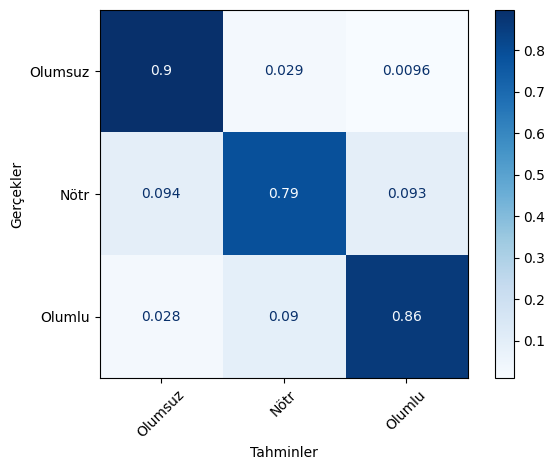

In [28]:
cm = confusion_matrix(true_labels, predictions,normalize='true')
labels = ['Rasgele Kelime', 'Olumsuz',  'Nötr',  'Olumlu','Tanımlayıcı']

index_to_remove = labels.index('Rasgele Kelime')
cm = np.delete(cm, index_to_remove, axis=0)
cm = np.delete(cm, index_to_remove, axis=1)
labels.remove('Rasgele Kelime')

index_to_remove = labels.index('Tanımlayıcı')
cm = np.delete(cm, index_to_remove, axis=0)
cm = np.delete(cm, index_to_remove, axis=1)
labels.remove('Tanımlayıcı')

plt.figure(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.tight_layout()
plt.xlabel("Tahminler")
plt.ylabel("Gerçekler")
plt.savefig("confusion-matrix.png", dpi=300)
plt.show()